In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn

In [3]:
credito = pd.read_csv('Credit.csv')

In [4]:
credito.shape

(1000, 21)

In [5]:
credito.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [7]:
for col in credito.columns:
    if credito[col].dtype == 'object':
        credito[col] = credito[col].astype('category').cat.codes

In [8]:
credito.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,2,6,1,7,1169,0,3,4,3,2,...,2,67,1,1,2,3,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,...,2,22,1,1,1,3,1,0,1,0
2,0,12,1,4,2096,3,1,2,3,2,...,2,49,1,1,1,2,2,0,1,1
3,2,42,3,5,7882,3,1,2,3,1,...,0,45,1,0,1,3,2,0,1,1
4,2,24,2,1,4870,3,0,3,3,2,...,1,53,1,0,2,3,2,0,1,0


In [9]:
previsores = credito.iloc[:,0:20].values
classe = credito.iloc[:,20].values

In [10]:
previsores

array([[ 2,  6,  1, ...,  1,  1,  1],
       [ 1, 48,  3, ...,  1,  0,  1],
       [ 0, 12,  1, ...,  2,  0,  1],
       ...,
       [ 0, 12,  3, ...,  1,  0,  1],
       [ 2, 45,  3, ...,  1,  1,  1],
       [ 1, 45,  1, ...,  1,  0,  1]], dtype=int64)

In [13]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(previsores, classe, test_size = 0.3, random_state=123)

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Modelo:  199ec4f14c0d41ee88a95a4763659747


D:\Anaconda\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


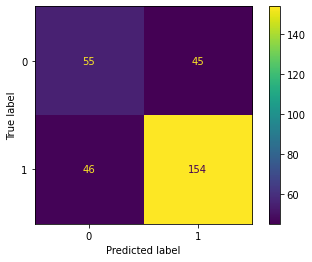

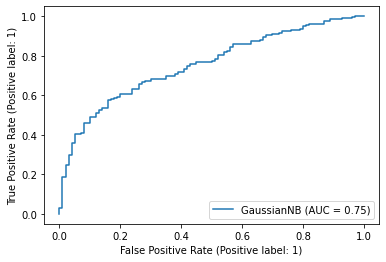

In [20]:
mlflow.set_experiment("nbexperimento")

with mlflow.start_run():
    naive_bayes = GaussianNB()
    naive_bayes.fit(X_treinamento, y_treinamento)
    previsoes = naive_bayes.predict(X_teste)
    
    #métricas
    acuracia = accuracy_score(y_teste, previsoes)
    recall = recall_score(y_teste, previsoes)
    precision = precision_score(y_teste, previsoes)
    f1 = f1_score(y_teste, previsoes)
    auc = roc_auc_score(y_teste, previsoes)
    log = log_loss(y_teste, previsoes)
    
    #registrar métricas
    mlflow.log_metric("acuracia", acuracia)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("log", log)
    
    #graficos
    confusion = plot_confusion_matrix(naive_bayes, X_teste, y_teste)
    plt.savefig("confusion.png")
    roc = plot_roc_curve(naive_bayes, X_teste, y_teste)
    plt.savefig("roc.png")
    
    #logar gráficos
    mlflow.log_artifact("confusion.png")
    mlflow.log_artifact("roc.png")
    
    #modelo
    mlflow.sklearn.log_model(naive_bayes, "ModeloNB")
    
    #informações da execução
    print("Modelo: ", mlflow.active_run().info.run_uuid)
    
mlflow.end_run()